<a href="https://colab.research.google.com/github/PawinData/TM/blob/main/TM_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import namedtuple
from pickle import dump, load

In [ ]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=19)  # read in training set
twenty_test  = fetch_20newsgroups(subset='test',  shuffle=True, random_state=29)  # read in test set

print("There are", len(twenty_train.filenames), "files in the training set under", len(twenty_train.target_names), "categories: \n")
for title in twenty_train.target_names:
    print(title)
print("")
print("There are", len(twenty_test.filenames), "files in the test set under", len(twenty_test.target_names), "categories.")

There are 11314 files in the training set under 20 categories: 

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc

There are 7532 files in the test set under 20 categories.


In [ ]:
# organize evaluation metrics with namedtuples
Train = namedtuple("Train", ["Precision","Recall","F1"])
Test  = namedtuple("Test", ["Precision","Recall","F1"])

def evaluate(truth, predicted, which_set):
    P = precision_score(truth, predicted, average="macro")
    R = recall_score(truth, predicted, average="macro")
    F = f1_score(truth, predicted, average="macro")
    if which_set=="Train":
        return Train(P,R,F)  
    else:
         return Test(P,R,F)

In [ ]:
# visualize classifier metrics
def viz_res(DF, TITLE=None, FigSize=(12,8), MarkerSize=12, fnts=18):
    fig,ax = plt.subplots(figsize=FigSize)
    for which_set in DF.columns:
        CLR = "darkblue" if which_set=="Train" else "darkolivegreen"
        ax.plot(DF.index, [cell.Precision for cell in DF[which_set]],
                color=CLR, marker="o", markersize=MarkerSize, linewidth=0,
                label="Precision for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.Recall for cell in DF[which_set]],
                color=CLR, marker="x", markersize=MarkerSize, linewidth=0,
                label="Recall for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.F1 for cell in DF[which_set]],
                color=CLR, marker="^", markersize=MarkerSize, linewidth=0,
                label="F1 for "+str(which_set)+" Set")
    for elements in ax.lines:
        xs = elements.get_xydata()[:,0]
        jittered_xs = xs + np.random.uniform(-0.25, 0.25, xs.shape)
        elements.set_xdata(jittered_xs)
        ax.relim()
        ax.autoscale(enable=True)
    plt.xlabel("Feature", fontsize=fnts)
    plt.ylabel("Score", fontsize=fnts)
    plt.ylim(0.5,1.05)
    plt.legend(loc="upper center", fontsize=int(0.8*fnts), ncol=2, bbox_to_anchor=(0.5,1.1))
    if TITLE is not None:
        plt.savefig(TITLE+".eps")
    plt.show()

# Naive Bayes Classifier

In [ ]:
NB = dict()

In [ ]:
# Train from Counts
NB_from_Counts = Pipeline([("vec_count", CountVectorizer()), ("clf", MultinomialNB())])
NB_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_Counts.predict(twenty_test.data)
# evaluate
NB["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
NB_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ('clf',MultinomialNB())])
NB_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_TF.predict(twenty_test.data)
# evaluate
NB["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
NB_from_tfIDF = Pipeline([('vec_count',CountVectorizer()), ('tfidf',TfidfTransformer()), ('clf', MultinomialNB()),])
NB_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_tfIDF.predict(twenty_test.data)
# evaluate
NB["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
NaiveBayes = pd.DataFrame(NB, index=["Train","Test"]).transpose()
NaiveBayes

,Train,Test
Counts,"(0.9348166390487324, 0.9228833755043991, 0.910...","(0.7621626411174734, 0.7636463041415988, 0.745..."
TF,"(0.8929939646270284, 0.819943011113042, 0.8114...","(0.7924314057319584, 0.6821951093902918, 0.672..."
tfIDF,"(0.9459403301595009, 0.9191027839411532, 0.919...","(0.8255310124210137, 0.756525006352595, 0.7557..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


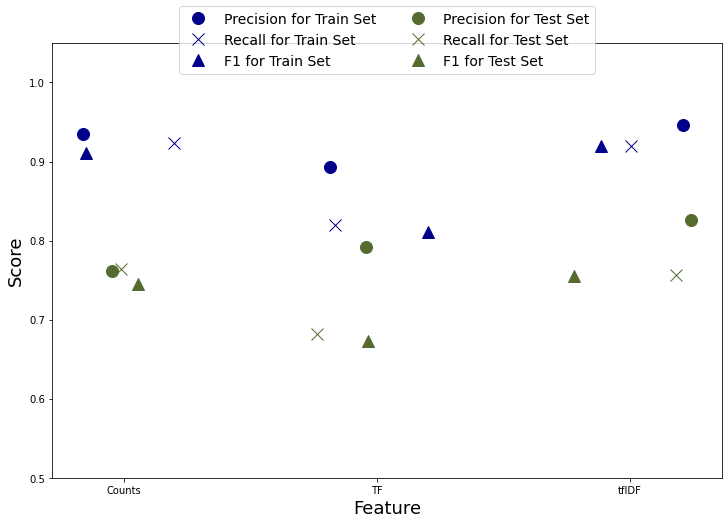

In [ ]:
viz_res(NaiveBayes, TITLE="Naive Bayes")

# Support Vector Machine Classifier

In [ ]:
SVM = dict()

In [ ]:
# Train from Counts
SVM_from_Counts = Pipeline([('vec_count', CountVectorizer()), 
                            ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=59,max_iter=5, tol=None)),
                          ])
SVM_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_Counts.predict(twenty_test.data)
# evaluate
SVM["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
SVM_from_TF = Pipeline([('vec_count', CountVectorizer()),
                        ('tf', TfidfTransformer(use_idf=False)),
                        ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=79,max_iter=5, tol=None)),
                       ])
SVM_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_TF.predict(twenty_test.data)
# evaluate
SVM["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
SVM_from_tfIDF = Pipeline([('vec_count', CountVectorizer()),
                           ('tfIDF', TfidfTransformer()),
                           ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=89,max_iter=5, tol=None)),
                          ])
SVM_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_tfIDF.predict(twenty_test.data)
# evaluate
SVM["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
SupportVectorMachine = pd.DataFrame(SVM, index=["Train","Test"]).transpose()
SupportVectorMachine

,Train,Test
Counts,"(0.9824892496018329, 0.9815918034591045, 0.981...","(0.7632170414670428, 0.7504747715611877, 0.752..."
TF,"(0.9176231701818622, 0.9055953533969816, 0.907...","(0.7789606373330445, 0.760413000061468, 0.7561..."
tfIDF,"(0.9676615733861244, 0.9619546416193036, 0.963...","(0.8267458608117908, 0.8120874662717542, 0.810..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


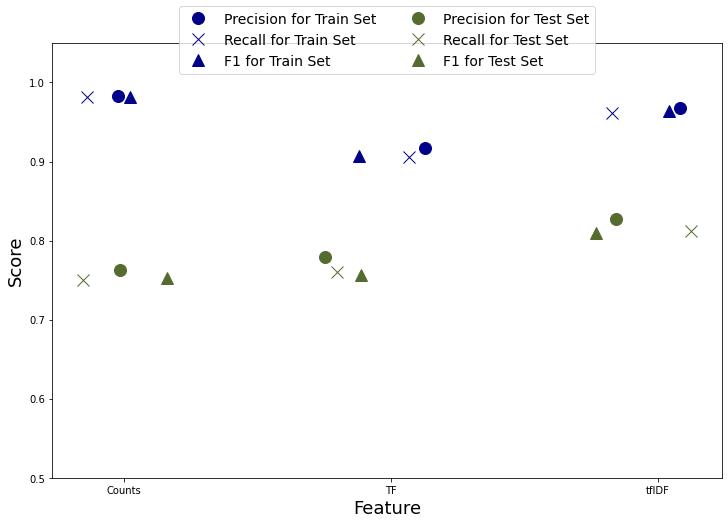

In [ ]:
viz_res(SupportVectorMachine, TITLE="Support Vector Machine")

# Decision Tree Classifier

In [ ]:
DT = dict()

In [ ]:
# Train from Counts
DT_from_Counts = Pipeline([("vec_count",CountVectorizer()), ("clf",DecisionTreeClassifier())])
DT_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_Counts.predict(twenty_test.data)
# evaluate
DT["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
DT_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ("clf",DecisionTreeClassifier())])
DT_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_TF.predict(twenty_test.data)
# evaluate
DT["TF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
DT_from_tfIDF = Pipeline([("vec_count",CountVectorizer()), ('tfIDF',TfidfTransformer()), ("clf",DecisionTreeClassifier())])
DT_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_tfIDF.predict(twenty_test.data)
# evaluate
DT["tfIDF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
DecisionTree = pd.DataFrame(DT, index=["Train","Test"]).transpose()
DecisionTree

,Train,Test
Counts,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5651378384228682, 0.5622791957078996, 0.561..."
TF,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5533521809378852, 0.5486264666428935, 0.549..."
tfIDF,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5507239937144977, 0.5473841689855157, 0.547..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


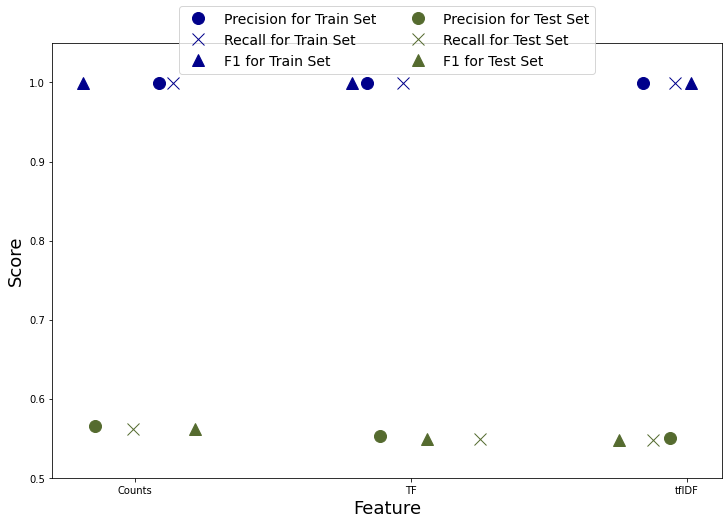

In [ ]:
viz_res(DecisionTree, TITLE="Decision Tree")

# Random Forest Classifier

In [ ]:
RF = dict()

In [ ]:
# Train from Counts
RF_from_Counts = Pipeline([("vec_count",CountVectorizer()), ("clf",RandomForestClassifier())])
RF_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_Counts.predict(twenty_test.data)
# evaluate
RF["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
RF_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ("clf",RandomForestClassifier())])
RF_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_TF.predict(twenty_test.data)
# evaluate
RF["TF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
RF_from_tfIDF = Pipeline([("vec_count",CountVectorizer()), ('tfIDF',TfidfTransformer()), ("clf",RandomForestClassifier())])
RF_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_tfIDF.predict(twenty_test.data)
# evaluate
RF["tfIDF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a datafram
RandomForest = pd.DataFrame(RF, index=["Train","Test"]).transpose()
RandomForest

,Train,Test
Counts,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.771988306996502, 0.7506418112588387, 0.7483..."
TF,"(0.9999165275459099, 0.9999158249158249, 0.999...","(0.7658374106292916, 0.7438267711594975, 0.742..."
tfIDF,"(0.9999165275459099, 0.9999158249158249, 0.999...","(0.7713064621910898, 0.7495104932061281, 0.747..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


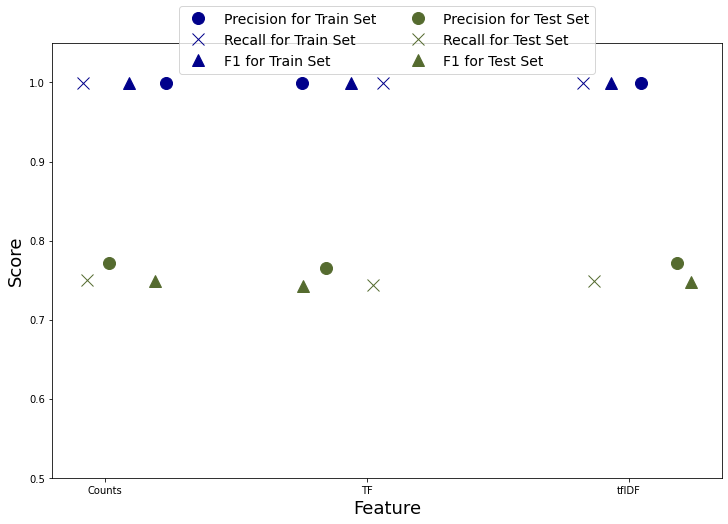

In [ ]:
viz_res(RandomForest, TITLE="Random Forest")

In [ ]:
RAW = dict()
RAW["Naive Bayes"] = NaiveBayes
RAW["SVM"] = SupportVectorMachine
RAW["Decision Tree"] = DecisionTree
RAW["Random Forest"] = RandomForest
dump(RAW, open("RawMetrics.p","wb"))

# Hyperparameters Tuning

All classifiers work sufficiently well on the training set. We will only report the performance metrics on the test set, after tuning four hyperparameters.

In [ ]:
import itertools
import time
import random

# Define combinations of CountVectorizer parameters
gridsearch_parameters = {'lowercase' : (True, False),
                         'stop_words' : ('english', ()),
                         'max_features' : (None, 10, 100, 1000),
                         'analyzer' : ('word', 'char', 'char_wb'),
                         'ngram_range' : ((1, 1), (1, 2), (2, 3))}
gridsearch_parameters = {'lowercase' : (True, False),
                         'stop_words' : ('english', ()),
                         'max_features' : (None, 1000),
                         'analyzer' : ('word', 'char'),
                         'ngram_range' : ((1, 1), (2, 3))}
gridsearch_combinations = list(itertools.product(*gridsearch_parameters.values()))
#gridsearch_combinations = [(True, 'english', None, 'word', (1, 1)), (True, (), None, 'word', (1, 1))] # test
print("Number of combinations:", len(gridsearch_combinations))

# Sample a smaller training set for grid searching
reduce_train_set = True
reduction = 0.80 # percentage of training set NOT to sample
random.seed(59) # set sampling seed
if reduce_train_set:
  print("Reducing dataset")
  sample = random.sample(range(len(twenty_train.data)), int((1 - reduction) * len(twenty_train.data)))
  train_set_small_x = [twenty_train.data[s] for s in sample]
  train_set_small_y = [twenty_train.target[s] for s in sample]
else:
  train_set_small_x = twenty_train.data
  train_set_small_y = twenty_train.target
print(len(train_set_small_x), "training samples")

# Try all combinations
print("\nStarting grid search")
GS_results = {}
for i, combo in enumerate(gridsearch_combinations):
  start_time = time.time()
  print(i+1, "out of", len(gridsearch_combinations), ":", combo)
  cv = CountVectorizer(lowercase=combo[0],
                       stop_words=combo[1],
                       max_features=combo[2],
                       analyzer=combo[3],
                       ngram_range=combo[4])
  SVM_GS = Pipeline([('vec_count', cv),
                    ('tfIDF', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=59,max_iter=5, tol=None))])
  
  # Fitting & eval with TF-IDF
  SVM_GS.fit(train_set_small_x, train_set_small_y)
  # predict for training set
  pred_train = SVM_GS.predict(twenty_train.data)
  # predict for test set
  pred_test = SVM_GS.predict(twenty_test.data) # the full test set
  # evaluate
  GS_results[combo] = [evaluate(twenty_train.target, pred_train, which_set="Train"), 
                       evaluate(twenty_test.target, pred_test, which_set="Test")]
  
  delta_time = time.time() - start_time
  print(GS_results[combo])
  print("(", delta_time, "seconds )")

In [ ]:
# Process the results of the grid search: show maxima, plot graph (?)
print("\nResult processing")
GS_matrix = np.array(list(GS_results.values()))[0]
print("Best precision:", np.max(GS_matrix[:, 0], axis=0), 
      "for", list(GS_results.keys())[np.argmax(GS_matrix[:, 0], axis=0)])
print("Best recall:", np.max(GS_matrix[:, 1], axis=0), 
      "for", list(GS_results.keys())[np.argmax(GS_matrix[:, 1], axis=0)])
print("Best F1:", np.max(GS_matrix[:, 2], axis=0), 
      "for", list(GS_results.keys())[np.argmax(GS_matrix[:, 2], axis=0)])

# Plot all: scatter precision vs. recall on test set
import math

markers = ['o', '^', '*', 's', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def getMarkerAndColor(numeric_key): # get a marker and a color for a plot point
  if numeric_key > len(markers) * len(colors):
    print("@getMarkerAndColor: numeric key exceeds capacity")
    return None

  marker = markers[numeric_key % len(markers)] # cycle
  color = colors[int(math.floor(numeric_key / len(colors)))]
  return (marker, color)

fig, ax = plt.subplots()
for i, (k, v) in enumerate(GS_results.items()):
  mrk, col = getMarkerAndColor(i)
  ax.scatter(v[0][0], v[0][1], marker=mrk, c=col, label=k)
ax.set_title("Recall vs. precision on test set for grid search")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
#ax.legend()
plt.show()

# Tuned Performance of Classifiers

In [ ]:
DF   # row = feature, column = classifier, cell = (P,R,F)

In [ ]:
def compare_viz(DF, TITLE=None, FigSize=(12,8), MarkerSize=10, fnts=18):
    CLR = ["darkorange", "darkviolet", "darkred", "dimgray"]
    pic,axs = plt.subplots(figsize=FigSize)
    for i,row in enumerate(DF.index):
        axs.plot(DF.columns, [ele.Precision for ele in DF.loc[row,]],
                 color=CLR[i], marker='o', markersize=MarkerSize, linewidth=0,
                 label="Precision by "+str(row))
        axs.plot(DF.columns, [ele.Recall for ele in DF.loc[row,]],
                 color=CLR[i], marker='x', markersize=MarkerSize, linewidth=0,
                 label="Recall by "+str(row))
        axs.plot(DF.columns, [ele.F1 for ele in DF.loc[row,]],
                 color=CLR[i], marker='^', markersize=MarkerSize, linewidth=0,
                 label="F1 by "+str(row))
    for elements in axs.lines:
        xs = elements.get_xydata()[:,0]
        jittered_xs = xs + np.random.uniform(-0.25, 0.25, xs.shape)
        elements.set_xdata(jittered_xs)
    axs.relim()
    axs.autoscale(enable=True)
    plt.xlabel("Classifier", fontsize=fnts)
    plt.ylabel("Accuracy Score", fontsize=fnts)
    plt.ylim(0.5, 1.05)
    plt.legend(loc="upper center", fontsize=int(0.8*fnts), 
               bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True)
    if TITLE is not None:
        plt.savefig(TITLE)
    plt.show()

In [ ]:
compare_viz(DF)